<a href="https://colab.research.google.com/github/zamirsiddiqui/subtheme-sentiments/blob/master/subTheme_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import numpy as np
import nltk
from nltk.corpus import stopwords #provides list of english stopwords
from bs4 import BeautifulSoup
import re
import httpimport

In [2]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
#import the attention layer (upload attention.py in session)
from attention import AttentionLayer

In [4]:
#fetch stop words
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Read files from github and combined all the sentiment in single column
url = 'https://raw.githubusercontent.com/zamirsiddiqui/subtheme-sentiments/master/Evaluation-dataset.csv'
raw_data = pd.read_csv(url, header = None)
raw_data_subset = raw_data[raw_data.columns[0:4]]
raw_data_subset.fillna('', inplace = True)
raw_data_subset['sentiment']=raw_data_subset.apply(lambda x:'%s %s %s' % (x[1],x[2],x[3]),axis=1)
raw_data_subset = raw_data_subset[[0,'sentiment']]
raw_data_subset.columns = ['review', 'sentiments']

In [9]:
#set max width to display
pd.set_option('display.max_colwidth', -1)
raw_data_subset.head()

,review,sentiments
0,"Tires where delivered to the garage of my choice,the garage notified me when they had been delivered. A day and time was arranged with the garage and I went and had them fitted,a Hassel free experience.",garage service positive ease of booking positive
1,"Easy Tyre Selection Process, Competitive Pricing and Excellent Fitting Service",garage service positive value for money positive
2,Very easy to use and good value for money.,value for money positive
3,Really easy and convenient to arrange,ease of booking positive
4,It was so easy to select tyre sizes and arrange local fitting. The prices were competitive,location positive value for money positive ease of booking positive


In [10]:
raw_data_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10132 entries, 0 to 10131
Data columns (total 2 columns):
review        10132 non-null object
sentiments    10132 non-null object
dtypes: object(2)
memory usage: 158.4+ KB


In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [0]:
#text cleaning
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [0]:
#call the function
cleaned_text = []
for t in raw_data_subset['review']:
    cleaned_text.append(text_cleaner(t,0))

In [15]:
cleaned_text[:5]

['tires delivered garage choice garage notified delivered day time arranged garage went fitted hassel free experience',
 'easy tyre selection process competitive pricing excellent fitting service',
 'easy use good value money',
 'really easy convenient arrange',
 'easy select tyre sizes arrange local fitting prices competitive']

In [16]:
#call the function
cleaned_summary = []
for t in raw_data_subset['sentiments']:
    cleaned_summary.append(text_cleaner(t,1))
cleaned_summary[:5]

['garage service positive ease of booking positive',
 'garage service positive value for money positive',
 'value for money positive',
 'ease of booking positive',
 'location positive value for money positive ease of booking positive']

In [0]:
#combined the cleaned review and sentiments again
data = pd.DataFrame()
data['review']=cleaned_text
data['sentiments']=cleaned_summary

In [18]:
data.head()

,review,sentiments
0,tires delivered garage choice garage notified delivered day time arranged garage went fitted hassel free experience,garage service positive ease of booking positive
1,easy tyre selection process competitive pricing excellent fitting service,garage service positive value for money positive
2,easy use good value money,value for money positive
3,really easy convenient arrange,ease of booking positive
4,easy select tyre sizes arrange local fitting prices competitive,location positive value for money positive ease of booking positive


In [0]:
data.dropna(axis=0,inplace=True)

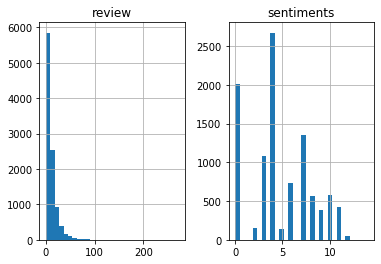

In [20]:
# check the distribution of review and sentiments
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['review']:
      text_word_count.append(len(i.split()))

for i in data['sentiments']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'review':text_word_count, 'sentiments':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [0]:
# above graph show that max lenght of review is 90 and sentiments is 12
max_text_len=90
max_summary_len=12

In [0]:
# take reviews upto max 90 words and reviews upto 12 words
cleaned_text =np.array(data['review'])
cleaned_summary=np.array(data['sentiments'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'review':short_text,'sentiments':short_summary})

In [0]:
#Remember to add the START and END special tokens at the beginning and end of the summary.
# Here, I have chosen sostok and eostok as START and END tokens
df['sentiments'] = df['sentiments'].apply(lambda x : 'sostok '+ x + ' eostok')

In [29]:
df.head()

,review,sentiments
0,tires delivered garage choice garage notified delivered day time arranged garage went fitted hassel free experience,sostok garage service positive ease of booking positive eostok
1,easy tyre selection process competitive pricing excellent fitting service,sostok garage service positive value for money positive eostok
2,easy use good value money,sostok value for money positive eostok
3,really easy convenient arrange,sostok ease of booking positive eostok
4,easy select tyre sizes arrange local fitting prices competitive,sostok location positive value for money positive ease of booking positive eostok


In [0]:
# devide the data in training 90% and validation 10%
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['review']),np.array(df['sentiments']),test_size=0.1,random_state=0,shuffle=True)

In [0]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [42]:
#Let us look at the proportion rare words and its total coverage in the entire text
#Here, I am defining the threshold to be 3 which means word whose count is below 3 is considered as a rare word
thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


#'tot_cnt' gives the size of vocabulary (which means every unique words in the text)
#'cnt' gives me the no. of rare words whose count falls below threshold
#'tot_cnt - cnt' gives me the top most common words

% of rare words in vocabulary: 61.853486319505734
Total Coverage of rare words: 4.014116403714048


In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [44]:
x_voc

2162

In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [46]:
thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 0.0
Total Coverage of rare words: 0.0


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [48]:
#Let us check whether word count of start token is equal to length of the training data
y_tokenizer.word_counts['sostok'],len(y_tr)

(9072, 9072)

In [0]:
#Here, I am deleting the rows that contain only START and END tokens
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [0]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [51]:
# Model Building
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:107: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:111: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 90, 100)      216200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 90, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
# I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence 
# to a one-hot vector on the fly. This overcomes any memory issues
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [0]:
#  Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [54]:
# We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7266 samples, validate on 808 samples
Epoch 1/50
7266/7266 [==============================] - 455s 63ms/sample - loss: 1.8355 - val_loss: 1.1588
Epoch 2/50
7266/7266 [==============================] - 446s 61ms/sample - loss: 0.8228 - val_loss: 0.5886
Epoch 3/50
7266/7266 [==============================] - 448s 62ms/sample - loss: 0.5316 - val_loss: 0.4625
Epoch 4/50
7266/7266 [==============================] - 482s 66ms/sample - loss: 0.4470 - val_loss: 0.4279
Epoch 5/50
7266/7266 [==============================] - 443s 61ms/sample - loss: 0.4049 - val_loss: 0.3711
Epoch 6/50
7266/7266 [==============================] - 445s 61ms/sample - loss: 0.3779 - val_loss: 0.3475
Epoch 7/50
7266/7266 [==============================] - 447s 62ms/sample - loss: 0.3561 - val_loss: 0.3391
Epoch 8/50
7266/7266 [==============================] - 446s 61ms/sample - loss: 0.3333 - val_loss: 0.3190
Epoch 9/50
7266/7266 [==============================] - 437s 60ms/sample - loss: 0.3197 - val_los

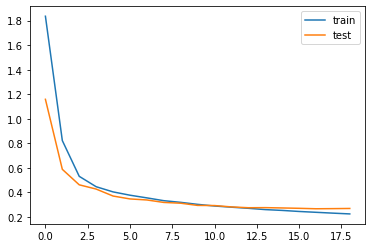

In [55]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
# woooooh getting traing / validation accuracy around 97.5 %

In [0]:
history.model.save('model.h5')

In [0]:
# let’s build the dictionary to convert the index to word for target and source vocabulary
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
# Set up the inference for the encoder and decoder
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [0]:
# We are defining a function below which is the implementation of the inference process 
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
# Let us define the functions to convert an integer sequence to a word sequence for sentiments as well as the reviews
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [62]:
# Lets checks few sentiments generated by the model:
for i in range(0,50):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: booked day fitted told delivered time given another date date told wait days lost work days 
Original summary: ease of booking negative change of date negative delivery punctuality negative 
Predicted summary:  change of date negative ease of booking negative


Review: easy order book tyre fitting locally 
Original summary: ease of booking positive location positive 
Predicted summary:  ease of booking positive location positive


Review: good quality tyres competitive price process selecting quick easy garage chose fitted tyres quickly efficiently within hour 
Original summary: tyre quality positive value for money positive length of fitting positive 
Predicted summary:  length of fitting positive value for money positive


Review: good reliable realistic prices 
Original summary: value for money positive 
Predicted summary:  value for money positive


Review: attractive price spot service excellent fitting partner nothing find fault 
Original summary: value for money positive

In [0]:
# create data frame with consist of reviews, Actual Sentiments and Predicted Sentiments
result = pd.DataFrame({'Review': [], 'Actual Sentiments': [], 'Predicted Sentiments': []})
for i in range(0,7266):
    result = result.append({'Review': seq2text(x_tr[i]), 'Actual Sentiments': seq2summary(y_tr[i]), 'Predicted Sentiments': decode_sequence(x_tr[i].reshape(1,max_text_len))}, ignore_index=True)

In [0]:
#Save final result in "Result.csv"
result.to_csv("Result.csv", index=False)